# chapter8. 비지도학습

## 8.1 K-평균 알고리즘
- 클러스터링 : 입력 데이터로부터 특성을 뽑아 유사 성질들을 군집화
- k-means : 각 클러스터(그룹)의 평균을 기준으로 점들을 배치시키는 알고리즘
- 특정 거리 함수를 통해 각 중심(centroid)과 입력값의 거리를 측정하고 그 중 가장 가까운 그룹으로 할당을 함
- 모든 점이 할당되면 각 그룹의 평균을 구해 중심을 업데이트하고 위 과정을 반복

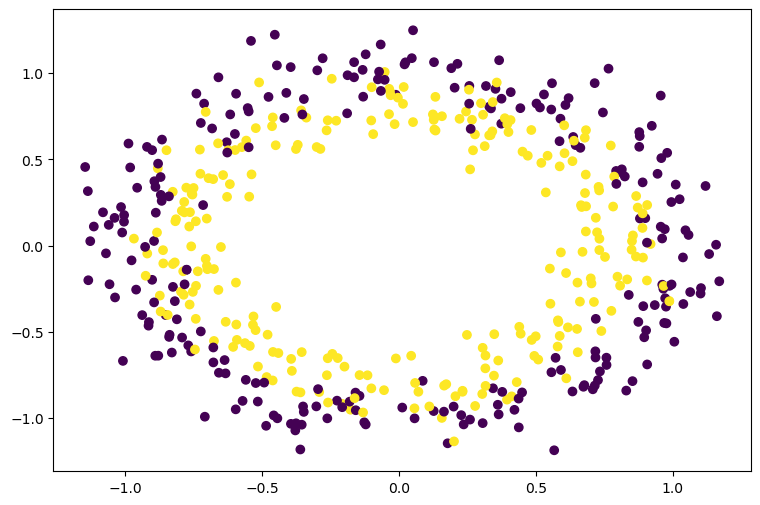

In [8]:
# 데이터 만들기
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

x, y = make_circles(n_samples=500, noise=0.1)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0],x[:,1], c=y)
plt.show()

In [9]:
# 텐서 데이터로 변환하기
x = torch.FloatTensor(x)

In [10]:
# K-means
def l2distance(a,b):
    return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0)

In [11]:
def kmeans(x, num_clusters = 2, max_iteration = 5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = x.to(device)
    centroids = torch.rand(num_clusters, x.size(1)).to(device)
    for update in range(x.size(0)):
        y_assign = []
        for m in range(x.size(0)):
            h = x[m].expand(num_clusters,-1) # 입력값을 클러스터 개수만큼 복사하여 할당
            assign = l2distance(h,centroids)
            y_assign.append(assign.item())

        y_assign = np.array(y_assign)
        if update != max_iteration-1:
            for i in range(num_clusters):
                idx = np.where(y_assign == i)[0]
                centroids[i] = torch.mean(x[idx], dim=0)
    return y_assign, centroids


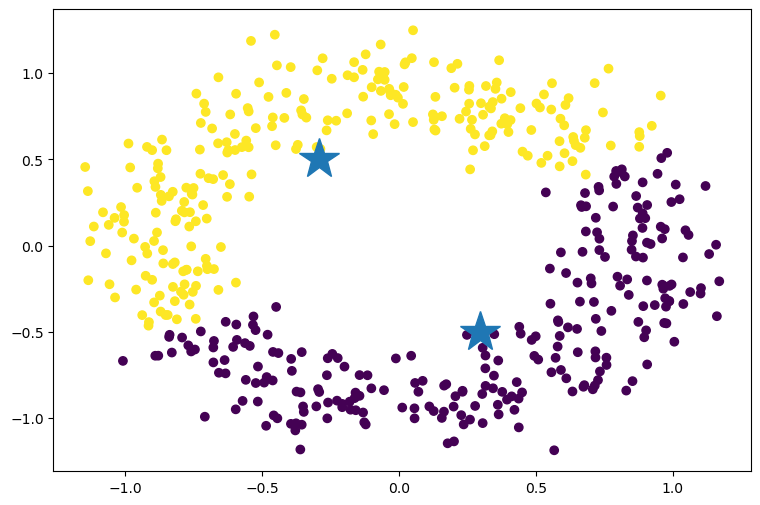

In [12]:
# 알고리즘 실행 및 그래프 그리기
y_pred, centroids = kmeans(x,2)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0],x[:,1], c=y_pred)
plt.plot(centroids[:,0],centroids[:,1],'*',markersize = 30)
plt.show()


## 8.3 오토인코더
- 오토인코더는 정답 없이 모델을 학습시키는 비지도 학습 모델
- 인코더 : 입력데이터를 압축, 디코더 : 압축을 품
- 인코더를 통해 차원 축소가 된 latent variable (잠재변수)를 가지고 별도로 계산을 할수도 있고 디코더를 통해 입력값과 유사한 값을 생성할 수 도 있다.

### 8.3.1 스택 오토인코더

In [13]:
# 라이브러리
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size = 50, shuffle= True)

100%|██████████| 9912422/9912422 [00:03<00:00, 2808633.19it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3073028.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1422329.61it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12898123.74it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [14]:
# 모델 구축하기
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128,32),
            nn.ReLU(),
            nn.Linear(32,10),
            nn.ReLU())
        
        self.decoder = nn.Sequential(
            nn.Linear(10,32),
            nn.ReLU(),
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid())    
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
# 모델, 손실함수, 최적화

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
# 학습하기
for epoch in range(51):
    running_loss = 0.0
    for data in trainloader:
        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.view(-1,28*28))
        outputs = outputs.view(-1,1,28,28)
        loss = criterion(inputs,outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    cost = running_loss/len(trainloader)
    print('[%d] loss : %.3f' % (epoch+1,cost))

### 8.3.2 디노이징 오토인코더

- 기본적인 목적 : 새로운 데이터를 만드는 것 
- 입력값에 노이즈를 주입, 신경망에 드롭아웃을 적용하여 출력 데이터를 생성하고 출력 데이터와 노이즈가 없는 원래 입력 데이터를 가지고 손실 함수를 계산한다.
- 따라서 노이즈가 있는 이미지를 가지고 노이즈가 없는 이미지와 유사한 데이터를 만드는 구조
- 이미지 복원이나 노이즈 제거 등에 사용됨

In [ ]:
# 가우시안 노이즈를 주입
# 학습하기 

for epoch in range(101):

    running_loss = 0.0
    for data in dataloader:

        inputs = data[0].to(device)
        optimizer.zero_grad()
        dirty_inputs = inputs + torch.normal(0,0.5, size = inputs.size()).to(device)
        outputs = model(dirty_inputs.view(-1,28*28))
        outputs = outputs.view(-1,1,28,28)
        loss = criterion(inputs, outputs)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    cost = running_loss / len(trainloader)
    print('[%d] loss: %.3f'%(epoch+1,cost))

### 8.3.3 합성곱 오토인코더

- nn.Linear 대신 합성곱 층 nn.Conv2d를 사용하는 구조
- 이미지 데이터가 일렬로 펴지지 않고 그대로 들어와 연산이 진행
- 잠재변수(latent variable) h는 일렬 형태인 벡터이기 때문에, 인코더에서 나온 피쳐맵을 일렬로 펴서 h를 추출하고 h를 은닉층을 거친 뒤 사각형 모양의 피쳐맵으로 만들어 디코더에 넣어준다.

In [ ]:
# 피쳐맵을 벡터화
class Flatten(torch.nn.Module):
    def forward(self,x):
        batch_size = x.shape[0]
        return x.view(batch_size,-1)

In [ ]:
# 벡터를 사각형 피쳐맵으로 변환하기
class Deflatten(nn.Module):
    def __init__(self, k):
        super(Deflatten, self).__init__()
        self.k = k

    def forward(self,x) :
        s = x.size()
        feature_size = int((s[1]//self.k)**.5)
        return x.view(s[0].self.k.feature_size, feature_size)


In [ ]:
# 모델, 손실함수, 최적화 기법 정의
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 학습하기
for epoch in range(51):
    running_loss = 0.0
    for data in trainloader:
        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    cost = running_loss/len(trainloader)
    if epoch % 10 == 0:
        print('[%d] loss : %.3f' % (epoch+1, cost))

## 8.4 생성적 적대 신경망 (GAN)

- 진짜 같은 가짜 데이터를 만들어 내는 기술
- 가짜 이미지를 만드는 생성자(generator)와 진짜 이미지와 가짜 이미지를 구별하는 구별자(discriminator)로 구성
- 손실함수는 이진 크로스 엔트로피 함수

### 8.4.1 Vanilla GAN

In [17]:
# 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid # 격자 형태 이미지
import imageio # gif파일을 만듦
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 패션 아이템 데이터 불러오기
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
trainset = FashionMNIST(root='./data/', train=True, download= True,transforms = transforms)
trainloader = DataLoader(trainset, batch_size =100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 생성자 구축하기
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784 # 28*28 크기인 벡터를 생성
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2), # 기울기 사라짐 방지를 위해 음수 구간의 양의 기울기를 주어 값을 계산
            nn.Linear(256,512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2),      
            nn.Linear(1024, self.n_out),
            nn.Tanh()      
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1,1,28,28)
        return x

In [ ]:
# 구별자 구축하기
class Discrimiator(nn.Module):
    def __init__(self):
        super(Discrimiator, self).__init__()
        self.n_in = 784
        self.n_out =1
        self.linear = nn.Sequential(
            nn.Linear(self,n_in,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1256,self.n_out),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = x.view(-1,784) # 이미지를 벡터 형태로 변경하여 신경망에 대입
        x = self.linear(x)
        return x

In [ ]:
# 모델 정의하기 
generator = Generator().to(device)
discriminator = Discrimiator().to(device)

# 손실함수 및 최적화
g_optim = optim.Adam(generator.parameters(),lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(),lr=2e-4)
g_losses = []
d_losses = []
images = []
criterion=nn.BCELoss() # 이진 크로스 엔트로피 함수

In [ ]:
# 잠재 변수 및 라벨 정의
def noise(n,n_features = 128):
    data = torch.randn(n,n_features) # 잠재변수 n개를 무작위로 생성
    return data.to(device)

def label_ones(size): # 진짜 데이터 라벨 = 1
    data = torch.ones(size,1)
    return data.to(device)

def label_zeros(size): # 생성자로부터 만들어진 이미지의 라벨 = 0
    data = torch.zeros(size,1)
    return data.to(device)

In [ ]:
# 구별자 학습 함수 정의하기
def train_discriminator(optimizer,real_data,fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    prediction_real = discriminator(real_data) # 진짜 이미지를 판별
    d_loss = criterion(prediction_real,label_ones(n))
    prediction_fake = discriminator(fake_data) # 가짜 이미지를 판별
    g_loss = criterion(prediction_fake, label_zeros(n))
    loss = d_loss +g_loss
    loss.backward()
    optimizer.step()
    return loss.item()
    

In [ ]:
# 생성자 학습 함수 정의하기
def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
# 모델 학습하기
test_noise = noise(64) # 검증을 위한 무작위 잠재 변수 64개를 생성
l = len(trainloader) # 평균 손실값을 구하는데 사용하는 배치 수를 저장
for epoch in range(151):
    g_loss = 0.0 # 각 에폭마다 손실값을 초기화
    d_loss = 0.0
    for data in trainloader:
        imgs,_ = data
        n = len(imgs) 
        fake_data = generator(noise(n)).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_loss +=train_generator(g_optim,fake_data)
    
    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)
    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch,g_loss/l, d_loss/l))

In [ ]:
# 모델 저장하기
torch.save(discriminator.state_dict(),'./models/fmnist_disc.pth')
torch.save(generator.state_dict(),'./models/fmnist_gner.pth')

# 검증 이미지 변화를 gif 파일로 저장하기
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items.gif',imgs)